# Restaurant Review Sentiment (Positive vs Negative)

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

## Importing dataset restaurant_revies.tsv

In [2]:
df=pd.read_csv('Restaurant_Reviews.tsv',delimiter='\t',quoting=3)

In [3]:
print(df.head())

                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


## Checking for missing values

In [5]:
df.isnull().sum()

Review    0
Liked     0
dtype: int64

## Class Distribution

In [6]:
print(df['Liked'].value_counts())

Liked
1    500
0    500
Name: count, dtype: int64


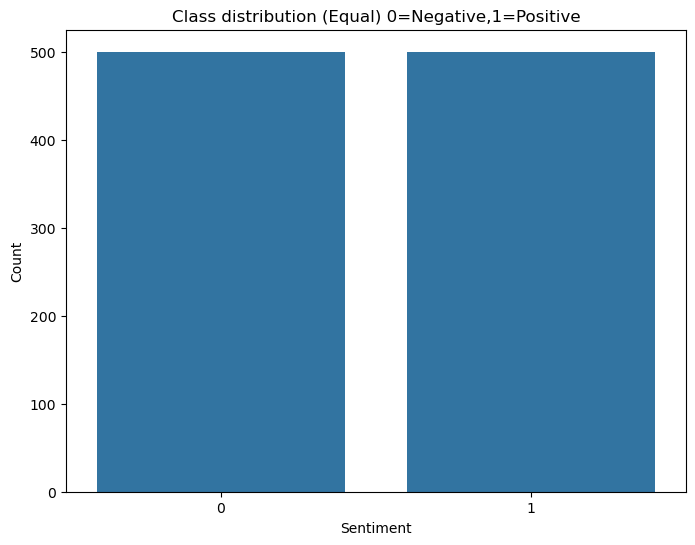

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(x='Liked',data=df)
plt.title('Class distribution (Equal) 0=Negative,1=Positive')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Creating Word count and Char count features for more context

In [8]:
df['word_count']=df['Review'].apply(lambda x:len(str(x).split()))
df['char_count']=df['Review'].apply(lambda x:len(str(x)))

In [9]:
def avg_word_len(text):
    words=str(text).split()
    if len(words)==0:
        return 0
    return sum (len(word) for word in words)/len(words)
df['avg_word_len']=df['Review'].apply(avg_word_len)

In [10]:
df.head()

,Review,Liked,word_count,char_count,avg_word_len
0,Wow... Loved this place.,1,4,24,5.250000
1,Crust is not good.,0,4,18,3.750000
2,Not tasty and the texture was just nasty.,0,8,41,4.250000
3,Stopped by during the late May bank holiday of...,1,15,87,4.866667
4,The selection on the menu was great and so wer...,1,12,59,4.000000


## Plotting new features

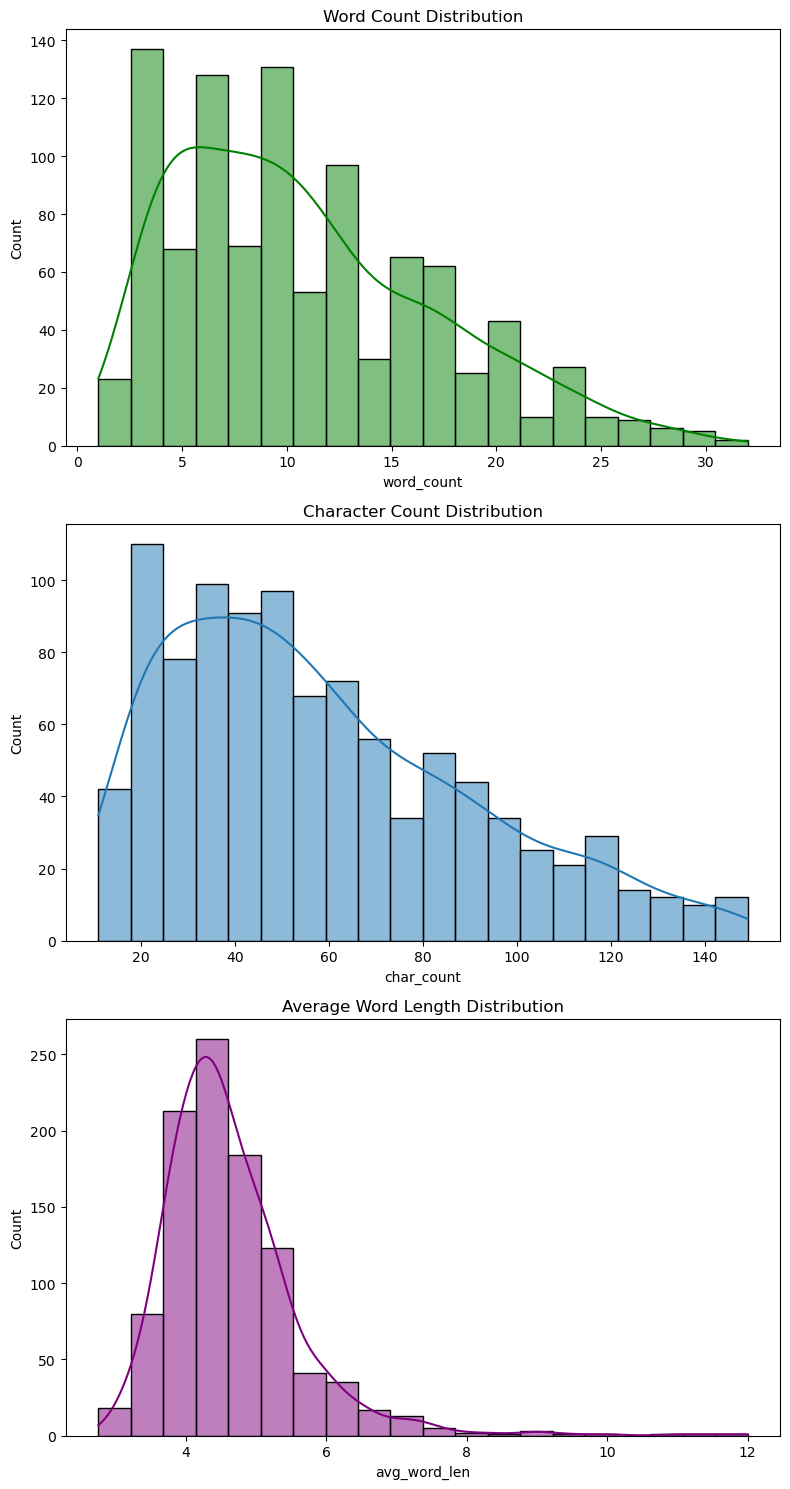

In [11]:
plt.figure(figsize=(8, 15))

plt.subplot(3, 1, 1)
sns.histplot(df['word_count'], bins=20, kde=True,color='Green')
plt.title('Word Count Distribution')


plt.subplot(3, 1, 2)
sns.histplot(df['char_count'], bins=20, kde=True)
plt.title('Character Count Distribution')


plt.subplot(3, 1, 3)
sns.histplot(df['avg_word_len'], bins=20, kde=True,color='Purple')
plt.title('Average Word Length Distribution')
plt.tight_layout()
plt.show()

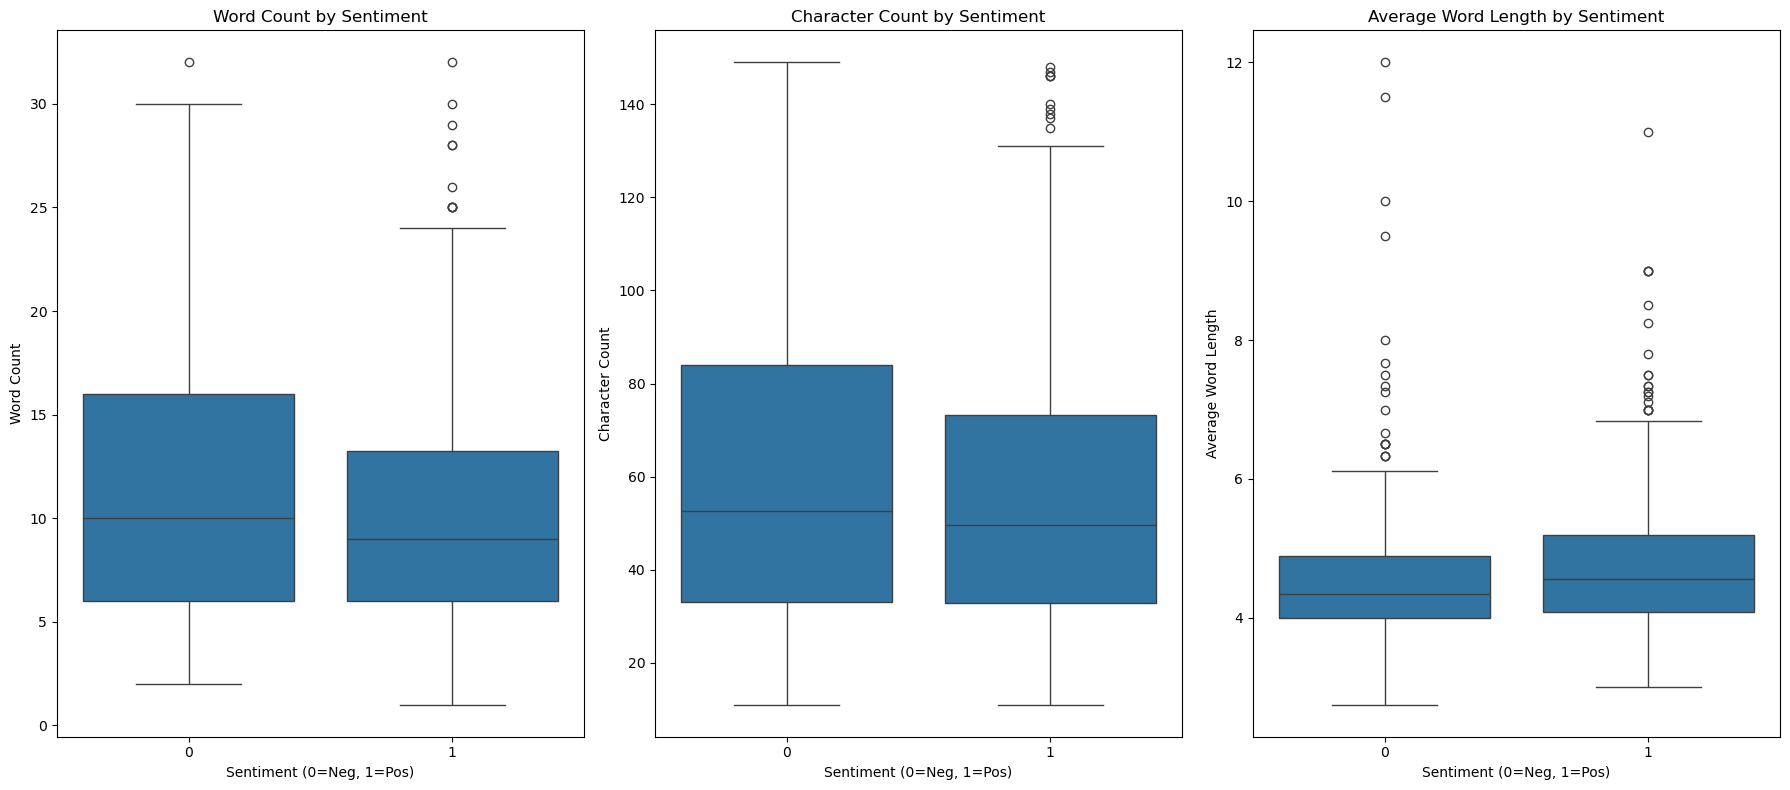

In [12]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
sns.boxplot(x='Liked', y='word_count', data=df)
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment (0=Neg, 1=Pos)')
plt.ylabel('Word Count')

plt.subplot(1, 3, 2)
sns.boxplot(x='Liked', y='char_count', data=df)
plt.title('Character Count by Sentiment')
plt.xlabel('Sentiment (0=Neg, 1=Pos)')
plt.ylabel('Character Count')

plt.subplot(1, 3, 3)
sns.boxplot(x='Liked', y='avg_word_len', data=df)
plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment (0=Neg, 1=Pos)')
plt.ylabel('Average Word Length')

plt.tight_layout()
plt.show()

In [13]:
df.drop('avg_word_len',axis=1)

,Review,Liked,word_count,char_count
0,Wow... Loved this place.,1,4,24
1,Crust is not good.,0,4,18
2,Not tasty and the texture was just nasty.,0,8,41
3,Stopped by during the late May bank holiday of...,1,15,87
4,The selection on the menu was great and so wer...,1,12,59
...,...,...,...,...
995,I think food should have flavor and texture an...,0,12,66
996,Appetite instantly gone.,0,3,24
997,Overall I was not impressed and would not go b...,0,10,50
998,"The whole experience was underwhelming, and I ...",0,16,91


### From this we find very little correlation that Negative reviews tend to have more words and characters and positive reviews tend to have less words and characters. Word length is inconclusive as there is minimal difference between 0 and 1

# Text Cleaning 

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
stop_word=stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
print(stop_word)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Removing stopword 'not' as it effects the sentiment vastly

In [16]:
list_to_remove=['isn','no','wouldn',"won't",'not',"isn't",'couldn',"couldn't",'did','didn',"didn't","doesn't","don't",'isnt',"hadn't","hasn't","haven't",'isn','no','nor',"shouldn't","wasn't","weren't","wouldn't"]
for word in list_to_remove:
     if word not in stop_word:
         continue
     else:
       stop_word.remove(word)


In [18]:
corpus=[]
st=SnowballStemmer(language='english')
for i in range(0,1000):
    review=re.sub('[^a-zA-Z]',' ',df['Review'][i])
    review=review.lower()
    review=review.split()
    review=[st.stem(word) for word in review if not word in stop_word]
    review=' '.join(review)
    corpus.append(review)


In [19]:
print(corpus)

['wow love place', 'crust not good', 'not tasti textur nasti', 'stop late may bank holiday rick steve recommend love', 'select menu great price', 'get angri want damn pho', 'honeslti didn tast fresh', 'potato like rubber could tell made ahead time kept warmer', 'fri great', 'great touch', 'servic prompt', 'would not go back', 'cashier no care ever say still end wayyy overpr', 'tri cape cod ravoli chicken cranberri mmmm', 'disgust pretti sure human hair', 'shock no sign indic cash', 'high recommend', 'waitress littl slow servic', 'place not worth time let alon vega', 'did not like', 'burritto blah', 'food amaz', 'servic also cute', 'could care less interior beauti', 'perform', 'right red velvet cake ohhh stuff good', 'never brought salad ask', 'hole wall great mexican street taco friend staff', 'took hour get food tabl restaur food luke warm sever run around like total overwhelm', 'worst salmon sashimi', 'also combo like burger fri beer decent deal', 'like final blow', 'found place acci

## Creating the TF-IDF model

In [20]:
tfidf = TfidfVectorizer(max_features=1500)
X=tfidf.fit_transform(corpus).toarray()
y=df['Liked'].values

## Splitting the dataset into train and test

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


## Applying Logistic Regression

In [38]:
logclass=LogisticRegression(random_state=0)
logclass.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Logistic Regression Results

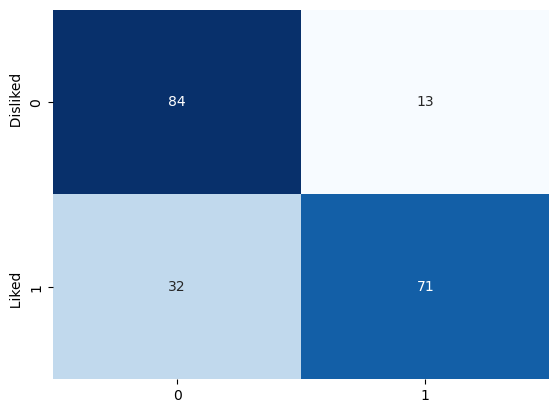

In [39]:
y_pred_log=logclass.predict(X_test)
cmlog=confusion_matrix(y_test,y_pred_log)
sns.heatmap(cmlog,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.ylabel('  Liked                                 Disliked')
plt.show()

In [40]:
scores = cross_val_score(logclass, X, y, cv=5, scoring="accuracy")
print("Accuracy: {:.2f} %".format(scores.mean()*100))
print("Standard Deviation: {:.2f} %".format(scores.std()*100))

Accuracy: 80.50 %
Standard Deviation: 1.38 %


In [41]:
print(np.concatenate((y_test.reshape(len(y_test),1),y_pred_log.reshape(len(y_pred_log),1)),1))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]

## Applying Multinomial Naive Bayes

In [42]:
bayesclf=MultinomialNB()
bayesclf.fit(X_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## Multinomial Bayes Results

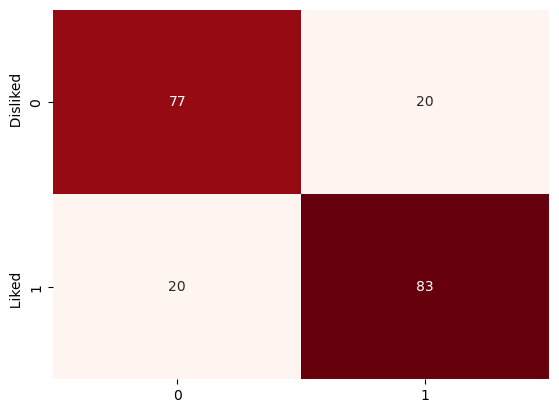

In [43]:
y_pred_nb=bayesclf.predict(X_test)
cmnb=confusion_matrix(y_test,y_pred_nb)
sns.heatmap(cmnb,annot=True,fmt='d',cmap='Reds',cbar=False)
plt.ylabel('  Liked                                 Disliked')
plt.show()

In [44]:
scores_nb = cross_val_score(bayesclf, X, y, cv=5, scoring="accuracy")
print("Accuracy: {:.2f} %".format(scores_nb.mean()*100))
print("Standard Deviation: {:.2f} %".format(scores_nb.std()*100))

Accuracy: 78.20 %
Standard Deviation: 2.11 %


In [45]:
print(np.concatenate((y_test.reshape(len(y_test),1),y_pred_log.reshape(len(y_pred_nb),1)),1))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]

## Applying linear SVC

In [46]:
svclf=SVC(kernel='linear',random_state=0)
svclf.fit(X_train,y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## SVC Results

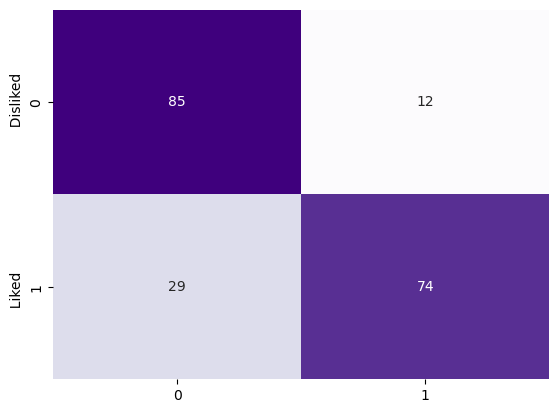

In [47]:
y_pred_svc=svclf.predict(X_test)
cmsvc=confusion_matrix(y_test,y_pred_svc)
sns.heatmap(cmsvc,annot=True,fmt='d',cmap='Purples',cbar=False)
plt.ylabel('  Liked                                 Disliked')
plt.show()

In [48]:
scores_svc = cross_val_score(svclf, X, y, cv=5, scoring="accuracy")
print("Accuracy: {:.2f} %".format(scores_svc.mean()*100))
print("Standard Deviation: {:.2f} %".format(scores_svc.std()*100))

Accuracy: 79.50 %
Standard Deviation: 1.26 %


In [33]:
print(np.concatenate((y_test.reshape(len(y_test),1),y_pred_log.reshape(len(y_pred_svc),1)),1))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]

## Word Clouds for positive and negative Sentiments

In [35]:
word_cloud_corpus=[]
for i in range(0,1000):
    sreview=re.sub('[^a-zA-Z]',' ',df['Review'][i])
    sreview=sreview.lower()
    sreview=sreview.split()
    sreview=[word for word in sreview if word not in stop_word]
    sreview=' '.join(sreview)
    word_cloud_corpus.append(sreview)

In [36]:
df['cleaned_human_readable']=word_cloud_corpus
positive_text=" ".join(sreview for sreview in df[df['Liked']==1]['cleaned_human_readable'])
negative_text=" ".join(sreview for sreview in df[df['Liked']==0]['cleaned_human_readable'])

## Positive Reviews

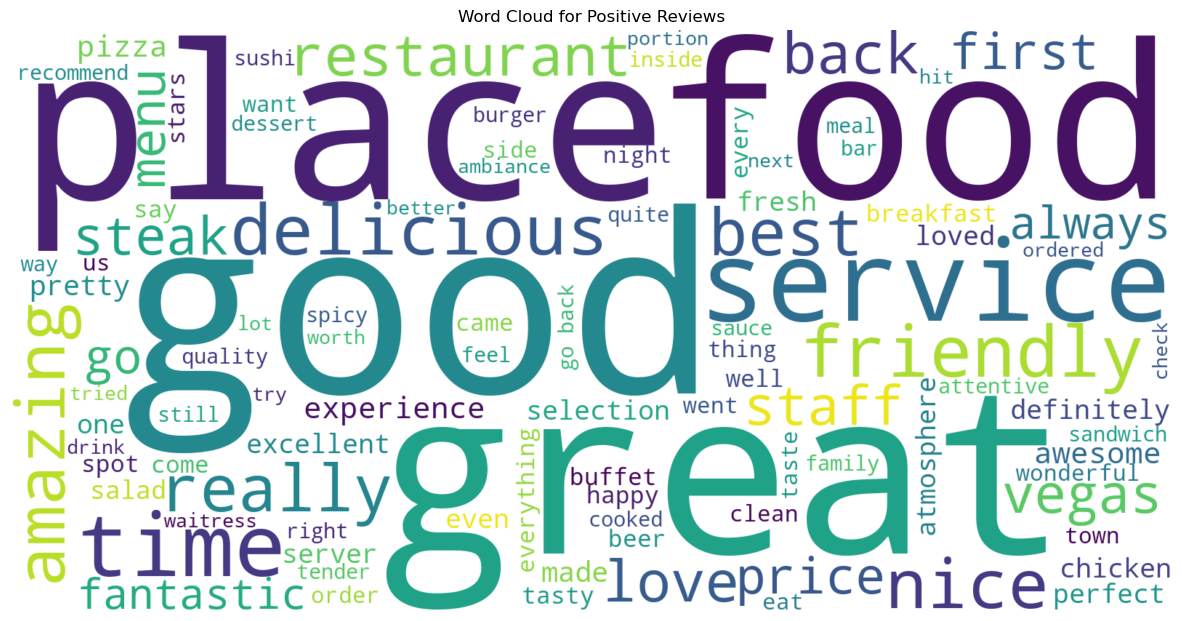

In [37]:
wordcloud_pos = WordCloud(
    width=1600, 
    height=800, 
    background_color="white", 
    max_words=100
).generate(positive_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_pos,interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis("off")
plt.show()

## Negative Reviews

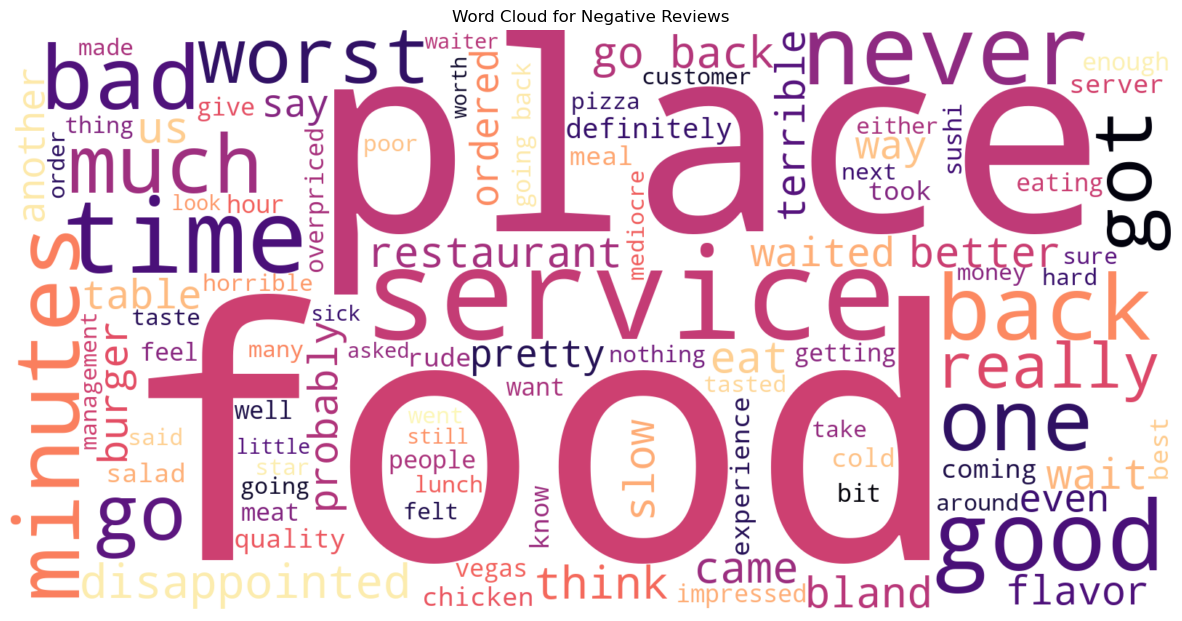

In [258]:
wordcloud_neg=WordCloud(width=1600,height=800,background_color="white",max_words=100,colormap='magma').generate(negative_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_neg,interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis("off")
plt.show()

# Results

##  Model Comparison & Results

To evaluate the performance of our models, we used 5-fold cross-validation on the dataset. This provides a reliable measure of how each model would perform on unseen data.

The table below shows the average accuracy and standard deviation for each classifier:

### TF-IDF Results

| Model | Average Accuracy | Standard Deviation |
| :--- | :--- | :--- |
| **Logistic Regression** | **80.50%** | **&plusmn; 1.38%** |
| LinearSVC (SVM) | 79.50% | &plusmn; 1.26% |
| Multinomial Naive Bayes | 78.20% | &plusmn; 2.11% |


##  Conclusion

All three models performed well, with accuracies clustered closely together.

The **Logistic Regression** model was the top performer, achieving the highest average accuracy of **80.50%**. Its standard deviation was also relatively low, indicating consistent performance across the different data folds. This suggests that the SVM was the most robust and effective model for this particular sentiment analysis task.